In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pandas as pd
from datetime import datetime
import time
from pandas.api.types import CategoricalDtype

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('default') 
sbn.set(style="whitegrid") 

# **Satinización de archivos de edad y genero**

In [2]:
#Antes que nada, me intriga si los archivos de 'datos_navent' y los de 'hasta15/4' tienen overlap, son redundantes o consecutivos
genero_edad_postulantes = pd.read_csv(
    'datos/datos_navent/fiuba_2_postulantes_genero_y_edad.csv'
).merge(
    pd.read_csv('datos/hasta_15_4/fiuba_2_postulantes_genero_y_edad.csv'),
    on=['idpostulante','fechanacimiento','sexo'],
    how='outer'
)
def postulantes_str2timestamp(s): # debo
    if type(s) is datetime:
        return s
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except:
        return None
#veo que hay repetidos por id
#veo que hay gente (4) con sexo '0'
# Genero una funcion para satinizar archivos de postulantes_genero_edad
genero_categoria = CategoricalDtype(categories=["MASC","FEM","NO_DECLARA"], ordered=False)
def satinize_postulante_genero_edad(df):
    df['sexo'] = df['sexo'].astype(genero_categoria).fillna("NO_DECLARA")
    df = df.drop_duplicates(subset='idpostulante')
    df['fechanacimiento']= df['fechanacimiento'].map(postulantes_str2timestamp)
    mean_datetime = datetime.now()
    df['fechanacimiento']= df['fechanacimiento'].map(lambda it: it if it else mean_datetime)
    df['edad'] = df.fechanacimiento.apply(lambda it: 2018 - it.year)
    df = df[df.edad >17][df.edad<105]
    return df
genero_edad_postulantes = satinize_postulante_genero_edad(genero_edad_postulantes)
genero_edad_postulantes.shape[0]
educacion_postulantes = pd.read_csv(
    'datos/datos_navent/fiuba_1_postulantes_educacion.csv'
).merge(pd.read_csv('datos/hasta_15_4/fiuba_1_postulantes_educacion.csv'))
print(educacion_postulantes.isna().any()) #no hay nulos
print(educacion_postulantes.duplicated().value_counts())#ni duplicados
def generar_nivel_educativo(postulantes, educacion):
    #Considero como nivel educativo el maximo nivel que alcanzaron que fue completado.
    #Descarto estudios en curso o abandonados, quizas deba volver aca en algun momento
    tipo_estudio = CategoricalDtype(
        categories=["Otro","Secundario","Terciario/Técnico","Universitario","Posgrado","Master","Doctorado"],
        ordered=True
    )
    educacion = educacion[educacion.estado=='Graduado'].drop(['estado'],1)
    educacion.nombre= educacion.nombre.astype(tipo_estudio)
    educacion = educacion.sort_values(by='nombre',ascending=True)
    educacion = educacion.drop_duplicates(subset='idpostulante',keep='last')
    postulantes = postulantes.merge(educacion, on='idpostulante')
    postulantes = postulantes.rename(index=str,columns={'nombre':'nivel_educativo'})
    return postulantes.copy()
postulantes = generar_nivel_educativo(genero_edad_postulantes, educacion_postulantes)
del genero_edad_postulantes

/home/vasectomio/.virtualenv/datos/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vasectomio/.virtualenv/datos/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vasectomio/.virtualenv/datos/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

idpostulante    False
nombre          False
estado          False
dtype: bool
False    137072
dtype: int64


In [3]:
postulantes.head()

,idpostulante,fechanacimiento,sexo,edad,nivel_educativo
0,ZaO5,1978-08-10 00:00:00,FEM,40,Terciario/Técnico
1,NdJl,1969-05-09 00:00:00,MASC,49,Universitario
2,8BkL,1976-07-21 00:00:00,FEM,42,Master
3,NPBx,1981-03-09 00:00:00,MASC,37,Universitario
4,YGBY,1963-04-09 00:00:00,FEM,55,Terciario/Técnico


In [4]:
vistas = pd.concat([
    pd.read_csv('datos/hasta_15_4/fiuba_3_vistas.csv'),
    pd.read_csv('datos/datos_navent/fiuba_3_vistas.csv')
]).drop_duplicates()
print("nulos: ",vistas.isna().any()) #no hay nulos
print("duplicados: ",vistas.duplicated().value_counts())#ni duplicados

nulos:  idAviso         False
timestamp       False
idpostulante    False
dtype: bool
duplicados:  False    6682624
dtype: int64


In [5]:
def agregar_cantidad_anuncios(df, nombre_columna, anuncios):
    values = pd.DataFrame()
    value_counts = anuncios['idpostulante'].value_counts()
    values['idpostulante'] = value_counts.index
    values[nombre_columna] = value_counts.values
    df = pd.merge(df,values, on='idpostulante',how='outer')
    df[nombre_columna] = df[nombre_columna].fillna(0)
    return df
postulantes = agregar_cantidad_anuncios(postulantes, 'anuncios_vistos', vistas)

## postulaciones

In [6]:
postulaciones = pd.read_csv(
    'datos/datos_navent/fiuba_4_postulaciones.csv'
).merge(pd.read_csv('datos/hasta_15_4/fiuba_4_postulaciones.csv'))
print(postulaciones.count)
print(postulaciones.drop_duplicates().count) #no hay duplicados!
print(postulaciones.head())
def sanitize_postulaciones(df):
    postulaciones['date'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.date
    postulaciones['time'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.time
    return postulaciones.copy()
postulaciones = sanitize_postulaciones(postulaciones)
print(postulaciones.head())

<bound method DataFrame.count of             idaviso idpostulante     fechapostulacion
0        1112286523         ZaO5  2018-01-24 15:07:39
1        1112272060         ZaO5  2018-01-24 15:20:10
2        1112288401         ZaO5  2018-01-26 08:37:04
3        1112300563         ZaO5  2018-01-30 13:35:48
4        1112293018         ZaO5  2018-01-31 08:41:05
5        1112301287         ZaO5  2018-01-31 08:55:20
6        1112309589         ZaO5  2018-02-03 15:55:15
7        1112317020         ZaO5  2018-02-07 09:56:22
8        1112322363         ZaO5  2018-02-09 10:29:54
9        1112327122         ZaO5  2018-02-11 17:49:26
10       1112315062         ZaO5  2018-02-11 18:08:14
11       1112348722         ZaO5  2018-02-21 19:53:24
12       1112347076         ZaO5  2018-02-21 20:10:19
13       1112346704         ZaO5  2018-02-21 20:15:35
14       1112346547         ZaO5  2018-02-21 20:17:29
15       1112335122         ZaO5  2018-02-21 20:23:19
16       1112350663         ZaO5  2018-02-21 20:2

## Archivo 'avisos_detalle'

In [7]:
avisos_detalle = pd.concat([
    pd.read_csv('datos/datos_navent/fiuba_6_avisos_detalle.csv'),
    pd.read_csv('datos/hasta_15_4/fiuba_6_avisos_detalle.csv'),
    pd.read_csv('datos/fiuba_6_avisos_detalle_missing_nivel_laboral.csv')
])
#ESTE DF TIENE MUCHOS DATOS NULOS EN LAS COLUMNAS DE 'CIUDAD' y 'MAPACALLE'. 
#Decidimos eliminarlas ya que no nos parecieron muy relevantes para el analisis
#idpais solo tiene valor 1, la descripcion nunca es nula
#avisos_detalle.drop('descripcion',1,inplace=True)
tipo_trabajo = CategoricalDtype(
    categories=["Full-time","Part-time","Teletrabajo","Por Horas","Pasantia","Temporario","Por Contrato","Fines de Semana","Primer empleo"],
    ordered=True #de 'mas fijo' a 'menos fijo'
)
print(avisos_detalle)
avisos_detalle.nombre_area.value_counts()# hay muchas areas, no van a tener su propia categoria
def sanitize_aviso_detalle(df):
    df['tipo_de_trabajo'] = df['tipo_de_trabajo'].astype(tipo_trabajo)
    df = df.drop_duplicates(subset='idaviso')
    return df.drop(['ciudad','idpais','mapacalle'],1)
avisos_detalle = sanitize_aviso_detalle(avisos_detalle)

        idaviso  idpais                                             titulo  \
0       8725750       1                   VENDEDOR/A PROVINCIA DE SANTA FE   
1      17903700       1                                         Enfermeras   
2    1000150677       1                                     Chofer de taxi   
3    1000610287       1      CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA   
4    1000872556       1      Operarios de Planta - Rubro Electrodomésticos   
5    1001135716       1      Vendedor Viajante TUCUMAN/SANTIAGO DEL ESTERO   
6    1001326344       1           Vendedor Viajante RECONQUISTA/AVELLANEDA   
7    1001455648       1            Vendedor Viajante PILAR / ESCOBAR/TIGRE   
8       9240880       1  Productores Asesores Independiente, para venta...   
9    1001202662       1                              promotor/a , asesor/a   
10   1001724563       1                                         Paramédico   
11   1002181678       1                 Vendedor Viajante TIERRA

In [8]:
avisos_detalle.shape

(19696, 8)

## Archivo 'vistas'

In [9]:
vistas.head()
# Plantea la relación entre a y avisos

,idAviso,timestamp,idpostulante
0,1112400775,2018-04-06T01:43:47.445-0400,kPjr2K0
1,1112400775,2018-04-06T01:43:48.330-0400,kPjr2K0
2,1112426664,2018-04-06T01:43:50.042-0400,GNOwZmb
3,1112426664,2018-04-06T01:43:51.171-0400,GNOwZmb
4,1112445738,2018-04-06T01:43:46.371-0400,lDLxajz


## Arichivo 'avisos_online'

In [10]:
avisos_online = pd.read_csv(
    "datos/datos_navent/fiuba_5_avisos_online.csv"
).merge(
    pd.read_csv("datos/hasta_15_4/fiuba_5_avisos_online.csv")
) ##No tiene duplicados ni nulos
avisos_online.isna().any()

idaviso    False
dtype: bool

# Algunas exploraciones de cada archivo por separado

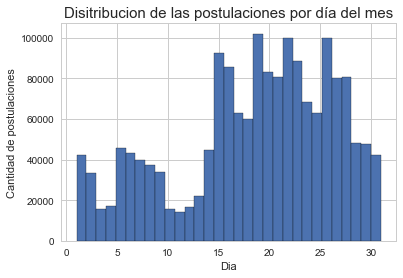

In [11]:
#Distribución de las postulaciones por dia del mes
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=31,edgecolor='black');
g_day.set_title('Disitribucion de las postulaciones por día del mes',fontsize=15)
g_day.set_xlabel('Dia')
g_day.set_ylabel('Cantidad de postulaciones');

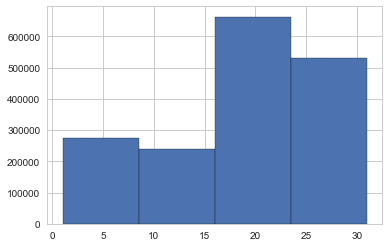

In [12]:
# ¿Será que uno se pone a buscar trabajo cuando se le empieza a acabar el sueldo?
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=4,edgecolor='black');

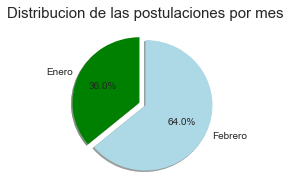

In [13]:
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero)

febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero)

sizes = [enero.count(),febrero.count()]
names = ['Enero', 'Febrero']

plt.figure(figsize=(3, 3))
plt.title('Distribucion de las postulaciones por mes', fontsize=15)
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90, colors=['green', 'lightblue'], explode=(0.1, 0),shadow=True)
plt.show()

In [14]:
# ¡Los datos empiezan a partir del 15/1!
postulaciones['date'].min()

datetime.date(2018, 1, 15)

Ambos graficos son engañosos.
El primero muestra que hay mas postulaciones en la segunda mitad de los meses pero eso es porque los datos de Enero son solo de la segunda mitad del mes.
De igual manera el sugundo grafico muestra que Enero tiene practicamente la mitad de postulaciones que Febrero.
Tambien se debe a lo comentado anteriormente, solo hay datos de la segunda mitad de Enero.

In [15]:
#Febrero tiene (casi)los dias completos
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero

,0
9,2018-02-28
5,2018-02-27
8,2018-02-26
26,2018-02-25
24,2018-02-24
11,2018-02-23
13,2018-02-22
4,2018-02-21
17,2018-02-20
16,2018-02-19


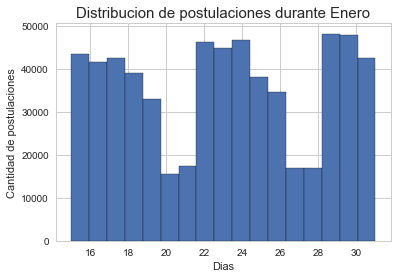

In [16]:
g_month_enero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]).dt.day.hist(bins=17,edgecolor='black');
g_month_enero.set_title('Distribucion de postulaciones durante Enero',fontsize=15)
g_month_enero.set_xlabel('Dias')
g_month_enero.set_ylabel('Cantidad de postulaciones');

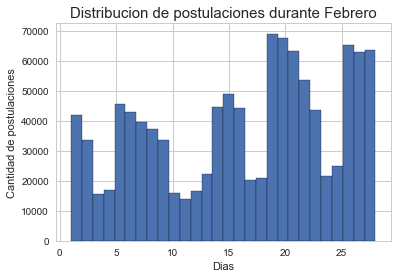

In [17]:
g_month_febrero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]).dt.day.hist(bins=28,edgecolor='black');
g_month_febrero.set_title('Distribucion de postulaciones durante Febrero',fontsize=15)
g_month_febrero.set_xlabel('Dias')
g_month_febrero.set_ylabel('Cantidad de postulaciones');

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana

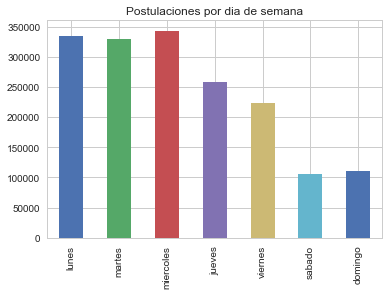

In [18]:
postulaciones['weekday']= pd.to_datetime(postulaciones['date']).dt.dayofweek
days = ['lunes','martes','miercoles','jueves','viernes','sabado','domingo']
postulaciones['weekday'] = pd.Categorical(values=postulaciones['weekday'].values, ordered=True).rename_categories(days)
postulaciones['weekday'].value_counts().sort_index().plot(kind='bar', title='Postulaciones por dia de semana')
# Al hacer el gráfico, podemos ver que los fines de semana tienen muchas menos postulaciones
# y que jueves y viernes son los dias de la semana con menos postulaciones.

In [19]:
#este df contiene solo los dias entre el 15 y 28 de cada mes
enero_febrero_igual_dias = pd.DataFrame(columns = ['date'])
enero_febrero_igual_dias['date'] = postulaciones['date'][(pd.to_datetime(postulaciones['date']).dt.day > 14) & (pd.to_datetime(postulaciones['date']).dt.day < 29)]

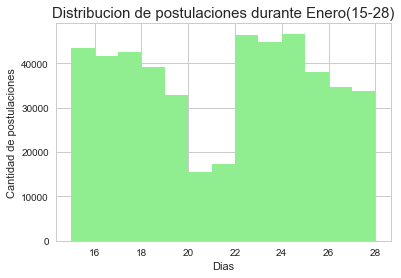

In [20]:
hist_enero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day.hist(bins=13,color= 'lightgreen');
hist_enero_edit.set_title('Distribucion de postulaciones durante Enero(15-28)',fontsize=15)
hist_enero_edit.set_xlabel('Dias')
hist_enero_edit.set_ylabel('Cantidad de postulaciones');

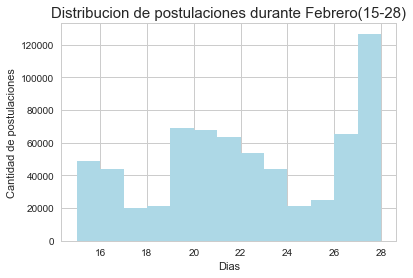

In [21]:
hist_Febrero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day.hist(bins=13,color='lightblue');
hist_Febrero_edit.set_title('Distribucion de postulaciones durante Febrero(15-28)',fontsize=15)
hist_Febrero_edit.set_xlabel('Dias')
hist_Febrero_edit.set_ylabel('Cantidad de postulaciones');

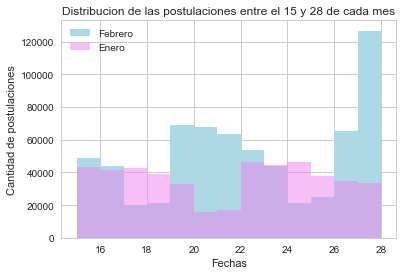

In [22]:
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day, bins=13,
         color='lightblue',label= 'Febrero')
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day,bins=13,
         color='violet',alpha=0.5, label='Enero')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones entre el 15 y 28 de cada mes')
plt.legend()
plt.show()

De esta última comparación se aprecia que el número de postulaciones es en general
mayor para febrero, y que el último día de febrero presenta un pico muy alto en 
las postulaciones.

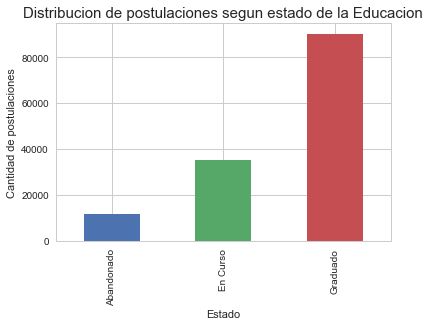

In [23]:
post_educ_estado = educacion_postulantes['estado'].value_counts().sort_index().plot(kind='bar')
post_educ_estado.set_title('Distribucion de postulaciones segun estado de la Educacion',fontsize=15)
post_educ_estado.set_xlabel('Estado')
post_educ_estado.set_ylabel('Cantidad de postulaciones');

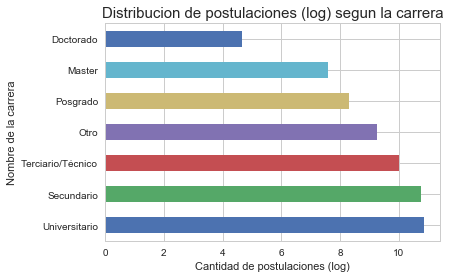

In [24]:
post_educ_carrera = np.log(educacion_postulantes['nombre'].value_counts() + 1).plot(kind='barh')
post_educ_carrera.set_title('Distribucion de postulaciones (log) segun la carrera',fontsize=15)
post_educ_carrera.set_ylabel('Nombre de la carrera')
post_educ_carrera.set_xlabel('Cantidad de postulaciones (log)');

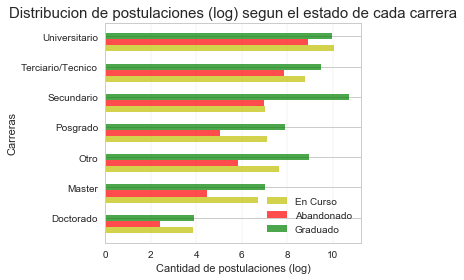

In [25]:
estado_y_carreras = educacion_postulantes[['nombre','estado']]
benchs_number = 7
benchs_names = ['Doctorado','Master','Otro','Posgrado','Secundario', 'Terciario/Tecnico','Universitario']

arch_en_curso = estado_y_carreras[estado_y_carreras['estado'] == 'En Curso']
arch_graduado = estado_y_carreras[estado_y_carreras['estado'] == 'Graduado']
arch_abandonado = estado_y_carreras[estado_y_carreras['estado'] == 'Abandonado']

#Uso una escala logaritmica asi se pueden ver mejor los datos en el grafico
en_curso = np.log(arch_en_curso['nombre'].value_counts() +1).sort_index()
abandonado = np.log(arch_abandonado['nombre'].value_counts() +1).sort_index()
graduado = np.log(arch_graduado['nombre'].value_counts() +1).sort_index()

index = np.arange(len(benchs_names))

bar_width = 0.2
opacity = 0.5

plt.barh(index, en_curso, bar_width, alpha=0.7,color='y',label='En Curso')
plt.barh(index+bar_width, abandonado, bar_width, alpha=0.7,color='r',label='Abandonado')
plt.barh(index+2*bar_width, graduado, bar_width, alpha=0.7,color='g',label='Graduado')

plt.grid(True, axis='x', linewidth=0.2)
plt.title('Distribucion de postulaciones (log) segun el estado de cada carrera',fontsize = 15)
plt.ylabel('Carreras')
plt.xlabel('Cantidad de postulaciones (log)')
plt.yticks(index + 2*bar_width, benchs_names)
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
edad_postulantes = pd.DataFrame(columns=['edad'])
edad_postulantes['edad'] = postulantes['edad'][(postulantes['edad'] > 17) & (postulantes['edad'] < 71)]
edad_postulantes['edad'] = edad_postulantes['edad'].astype(int)
edad_postulantes.sort_values(by='edad', ascending = True)

,edad
67093,18
66395,18
66138,18
68603,18
55578,18
68600,18
63680,18
67524,18
68150,18
61508,18


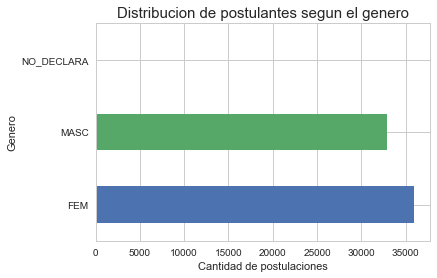

In [27]:
post_genero = postulantes['sexo'].value_counts().plot(kind='barh')
post_genero.set_title('Distribucion de postulantes segun el genero',fontsize=15)
post_genero.set_ylabel('Genero')
post_genero.set_xlabel('Cantidad de postulaciones');

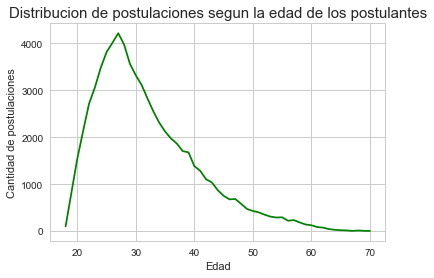

In [28]:
post_edad = edad_postulantes['edad'].value_counts().sort_index().plot(kind='line',color='green')
post_edad.set_title('Distribucion de postulaciones segun la edad de los postulantes',fontsize=15)
post_edad.set_xlabel('Edad')
post_edad.set_ylabel('Cantidad de postulaciones');



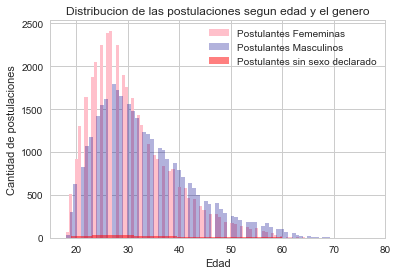

In [29]:
plt.hist(postulantes[postulantes.sexo == 'FEM'].edad, bins='auto' ,color='pink',label= 'Postulantes Fememinas')
plt.hist(postulantes[postulantes.sexo == 'MASC'].edad,bins='auto',color='darkblue',alpha=0.3, label='Postulantes Masculinos')
plt.hist(postulantes[postulantes.sexo == 'NO_DECLARA'].edad,bins='auto',color='red',alpha=0.5, label='Postulantes sin sexo declarado')

plt.xlabel('Edad')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones segun edad y el genero')
plt.xlim((15,80))
plt.legend()
plt.show()

In [30]:
#avisos_nivel_laboral = avisos_detalle['nivel_laboral'].value_counts().plot(kind='bar')
#avisos_nivel_laboral.set_title('Distribucion de los avisos laborales segun el nivel laboral pedido',fontsize=15)
#avisos_nivel_laboral.set_xlabel('Cantidad de avisos')
#avisos_nivel_laboral.set_ylabel('Nivel laboral');

avisos_detalle#['nivel_laboral'].value_counts()

,idaviso,titulo,descripcion,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL
5,1001135716,Vendedor Viajante TUCUMAN/SANTIAGO DEL ESTERO,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Ventas,Wurth Argentina S.A
6,1001326344,Vendedor Viajante RECONQUISTA/AVELLANEDA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Ventas,Wurth Argentina S.A
7,1001455648,Vendedor Viajante PILAR / ESCOBAR/TIGRE,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,Full-time,Junior,Ventas,Wurth Argentina S.A
8,9240880,"Productores Asesores Independiente, para venta...",Agente\r\noficial Selecciona:</span></strong><...,Capital Federal,Full-time,Jefe / Supervisor / Responsable,Comercial,Agencia Oficial Alejandro Arizaga
9,1001202662,"promotor/a , asesor/a",<p>En Cerantola nos encontramos en la busqueda...,Gran Buenos Aires,Full-time,Otro,Atención al Cliente,cerantola


19695

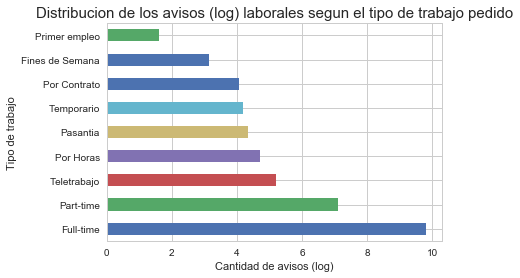

In [31]:
avisos_tipo_de_trabajo = np.log(avisos_detalle['tipo_de_trabajo'].value_counts()+1).plot(kind='barh')
avisos_tipo_de_trabajo.set_title('Distribucion de los avisos (log) laborales segun el tipo de trabajo pedido',fontsize=15)
avisos_tipo_de_trabajo.set_ylabel('Tipo de trabajo')
avisos_tipo_de_trabajo.set_xlabel('Cantidad de avisos (log)');

avisos_detalle['tipo_de_trabajo'].value_counts().sum()

Gran Buenos Aires              18022
Capital Federal                 1645
Buenos Aires (fuera de GBA)       17
GBA Oeste                         10
Corrientes                         1
Cordoba                            1
Name: nombre_zona, dtype: int64

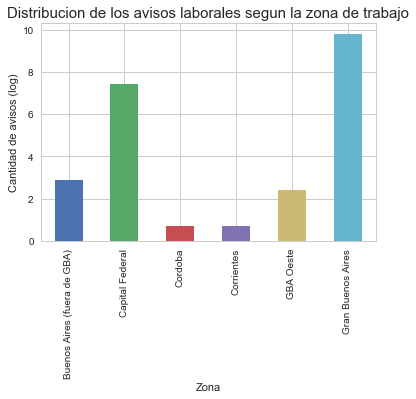

In [32]:
avisos_zona = np.log(avisos_detalle['nombre_zona'].value_counts() + 1).sort_index().plot(kind='bar')
avisos_zona.set_title('Distribucion de los avisos laborales segun la zona de trabajo',fontsize=15)
avisos_zona.set_xlabel('Zona')
avisos_zona.set_ylabel('Cantidad de avisos (log)');

avisos_detalle['nombre_zona'].value_counts()

# Merge de los datos
recuerdo la forma de los datasets

Text(0,0.5,'Cantidad de postulantes(log)')

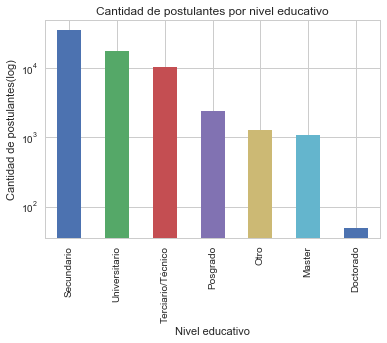

In [34]:
hist_educacion = postulantes['nivel_educativo'].value_counts().plot(logy=True, kind='bar')
hist_educacion.set_title('Cantidad de postulantes por nivel educativo')
hist_educacion.set_xlabel('Nivel educativo')
hist_educacion.set_ylabel('Cantidad de postulantes(log)')

Text(0,0.5,'Cantidad de anuncios vistos por postulante(log)')

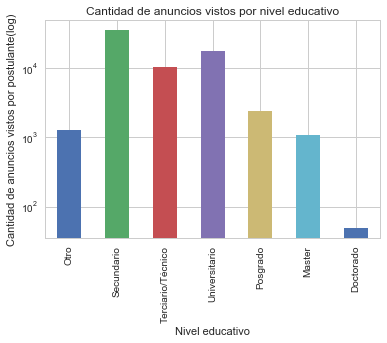

In [38]:
scatter_anuncios_vistos = postulantes.groupby('nivel_educativo').size().plot(kind='bar',logy=True)
scatter_anuncios_vistos.set_title('Cantidad de anuncios vistos por nivel educativo')
scatter_anuncios_vistos.set_xlabel('Nivel educativo')
scatter_anuncios_vistos.set_ylabel('Cantidad de anuncios vistos por postulante(log)')